# Intraventricular Hemorrage prediction in Preterm infants
Inspied by the paper:  
Machine learning models for identifying preterm infants at risk of cerebral hemorrhage. Varvara Turova, Irina Sidorenko

## Data preparation

In [988]:
#!pip install keras
#!pip install tensorflow
#!pip install -U imbalanced-learn, scikit-learn
#!pip install xgboost

In [989]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [990]:
# load data and set IVH level to binary 0 or 1
df = pd.read_csv('Table_preterm_2019_articleMLM.csv', sep=';')
df.columns = df.columns.str.lower().str.replace(' ','_') 
df.columns = df.columns.str.lower().str.replace(':','_') 
df.columns = df.columns.str.lower().str.replace(',','') 
df.columns = df.columns.str.lower().str.replace('-','_') 
df.columns = df.columns.str.lower().str.replace('/','_or_') 
df.columns = df.columns.str.lower().str.replace('#','') 

## Exploratory Analisis

In [609]:
#df.T
#df.gender.value_counts()
#df.birth__1_natural_2_caesarean.value_counts()

In [991]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

patient
[1 2 3 4 5]
316

wg
[23.5 23.6 24.4 24.1 24.2]
74

gender
[2 1 0]
3

body_weight
[490 450 335 850 710]
154

grad_ivh
[3 2 1 4 0]
5

day_of_ivh
[3 1 2 4 8]
17

birth__1_natural_2_caesarean
[2 1 3 4]
4

number_of_children
[1 2 3]
3

apgar_1min
[1. 2. 7. 5. 6.]
12

apgar_5min
[1 5 4 8 7]
11

apgar_10min
[2 6 7 0 8]
11

day_pf_life
[1.1 1.2 2.1 2.2 2.3]
167

day_befor_or_after_ivh
[-2.2 -2.1 -1.7 -1.6 -1.5]
146

ph
[0.   7.3  7.23 7.14 7.25]
421

pco2
[ 0.  36.1 49.1 52.7 39.9]
569

po2
[ 0.  47.2 50.9 49.7 44.1]
620

sao2
[ 0. 91. 30. 94. 90.]
70

map
[ 0 22 23 28 40]
78

leukocytes
[ 8.06  9.83  9.59  7.3  15.1 ]
1334

hematocrit
[0.    0.464 0.444 0.508 0.433]
375

thrombocytes
[197. 170. 134. 164. 159.]
367

crp
[0.  0.1 0.5 0.3 0.4]
93



In [994]:
# value count of eahc degree of hemorrage
degree_ivh = df.groupby('patient').grad_ivh.max()
vc = degree_ivh.value_counts()
vc

grad_ivh
0    170
3     49
2     45
1     44
4      8
Name: count, dtype: int64

## Data preprocessing

In [995]:
df_n = df[df.day_of_ivh == 0]
df_p = df[df.day_of_ivh > 1] # bigger than 1 cause not enough data
df_p_f = df_p[df_p.day_befor_or_after_ivh < 0]
dff = pd.concat([df_p_f,df_n], ignore_index=True)

In [996]:
dff['grad_ivh'] = dff['grad_ivh'].replace([1,2,3,4],1)

In [997]:
del dff['day_of_ivh']
del dff['day_befor_or_after_ivh']
del dff['day_pf_life']

In [998]:
columns = list(dff.columns)

In [1000]:
col_no_agg = [
    'wg', 'gender', 'body_weight', 'grad_ivh', 
    'birth__1_natural_2_caesarean',
    'number_of_children'
    ]

In [1003]:
# columns that don't need to be aggregated
col_no_agg = [
    'wg', 'gender', 'body_weight', 'grad_ivh', 
    'birth__1_natural_2_caesarean',
    'number_of_children'
    ]

# Performing aggregation of the datapüoints regarrding one patient
col_agg = [x for x in columns if x not in col_no_agg]
if len(col_agg)!=0:
    dff_agg = dff[col_agg].groupby('patient').agg(['mean', 'min', 'max']).reset_index()
    # Flattening the multi-level column names
    dff_agg.columns = ['_'.join(col) for col in dff_agg.columns]
    
# For col_no_agg, we simply take the first non-null occurrence (since we don't want to aggregate them)
dff_aggregated = dff.groupby('patient')[col_no_agg].first()
if len(col_agg)!=0:
    # Merge the two DataFrames back together on 'patient'
    dff_aggregated = pd.merge(dff_aggregated, dff_agg, left_on='patient', right_on='patient_')


In [1004]:
dff_aggregated.columns

Index(['wg', 'gender', 'body_weight', 'grad_ivh',
       'birth__1_natural_2_caesarean', 'number_of_children', 'patient_',
       'apgar_1min_mean', 'apgar_1min_min', 'apgar_1min_max',
       'apgar_5min_mean', 'apgar_5min_min', 'apgar_5min_max',
       'apgar_10min_mean', 'apgar_10min_min', 'apgar_10min_max', 'ph_mean',
       'ph_min', 'ph_max', 'pco2_mean', 'pco2_min', 'pco2_max', 'po2_mean',
       'po2_min', 'po2_max', 'sao2_mean', 'sao2_min', 'sao2_max', 'map_mean',
       'map_min', 'map_max', 'leukocytes_mean', 'leukocytes_min',
       'leukocytes_max', 'hematocrit_mean', 'hematocrit_min', 'hematocrit_max',
       'thrombocytes_mean', 'thrombocytes_min', 'thrombocytes_max', 'crp_mean',
       'crp_min', 'crp_max'],
      dtype='object')

In [1005]:
#del dff_aggregated['patient']
del dff_aggregated['patient_']

In [1006]:
dff_aggregated.isnull().sum()
dff_aggregated=dff_aggregated.fillna(0)
dff_aggregated.isnull().sum()
#fillna(0)

wg                              0
gender                          0
body_weight                     0
grad_ivh                        0
birth__1_natural_2_caesarean    0
number_of_children              0
apgar_1min_mean                 0
apgar_1min_min                  0
apgar_1min_max                  0
apgar_5min_mean                 0
apgar_5min_min                  0
apgar_5min_max                  0
apgar_10min_mean                0
apgar_10min_min                 0
apgar_10min_max                 0
ph_mean                         0
ph_min                          0
ph_max                          0
pco2_mean                       0
pco2_min                        0
pco2_max                        0
po2_mean                        0
po2_min                         0
po2_max                         0
sao2_mean                       0
sao2_min                        0
sao2_max                        0
map_mean                        0
map_min                         0
map_max       

## Validation split

In [1007]:
from sklearn.model_selection import train_test_split

In [1009]:
df_full_train , df_test = train_test_split(dff_aggregated, test_size=0.2, random_state=1)
df_train , df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [1011]:
len(df_train), len(df_val), len(df_test)

(178, 60, 60)

In [1012]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [1013]:
y_train = df_train.grad_ivh.values
y_val = df_val.grad_ivh.values
y_test = df_test.grad_ivh.values

In [1061]:
len(y_train)

178

In [1014]:
del df_train['grad_ivh']
del df_val['grad_ivh']
del df_test['grad_ivh']

In [1015]:
df_full_train.grad_ivh.value_counts(normalize=True)

grad_ivh
0    0.554622
1    0.445378
Name: proportion, dtype: float64

Now that the dataset is aggregated, it is balanced

In [1016]:
global_rate = df_full_train.grad_ivh.mean()
global_rate

0.44537815126050423

### features and mutual info

In [872]:
from IPython.display import display

In [873]:
features = list(df_full_train.columns)
features

['wg',
 'gender',
 'body_weight',
 'grad_ivh',
 'birth__1_natural_2_caesarean',
 'number_of_children',
 'apgar_1min_mean',
 'apgar_1min_min',
 'apgar_1min_max',
 'apgar_5min_mean',
 'apgar_5min_min',
 'apgar_5min_max',
 'apgar_10min_mean',
 'apgar_10min_min',
 'apgar_10min_max',
 'ph_mean',
 'ph_min',
 'ph_max',
 'pco2_mean',
 'pco2_min',
 'pco2_max',
 'po2_mean',
 'po2_min',
 'po2_max',
 'sao2_mean',
 'sao2_min',
 'sao2_max',
 'map_mean',
 'map_min',
 'map_max',
 'leukocytes_mean',
 'leukocytes_min',
 'leukocytes_max',
 'hematocrit_mean',
 'hematocrit_min',
 'hematocrit_max',
 'thrombocytes_mean',
 'thrombocytes_min',
 'thrombocytes_max',
 'crp_mean',
 'crp_min',
 'crp_max']

In [874]:
#for c in col_no_agg:
#    df_group = df_full_train.groupby(c).grad_ivh.agg(['mean', 'count'])
#    df_group['diff'] = df_group['mean'] - global_rate
#    df_group['risk'] = df_group['mean'] / global_rate
#    display(df_group)

In [875]:
df_full_train

,wg,gender,body_weight,grad_ivh,birth__1_natural_2_caesarean,number_of_children,apgar_1min_mean,apgar_1min_min,apgar_1min_max,apgar_5min_mean,...,leukocytes_max,hematocrit_mean,hematocrit_min,hematocrit_max,thrombocytes_mean,thrombocytes_min,thrombocytes_max,crp_mean,crp_min,crp_max
181,25.5,1,790,0,2,1,6.0,6.0,6.0,9.0,...,10.30,0.133250,0.000,0.522,73.500000,0.0,292.0,0.266667,0.0,1.2
107,28.4,2,1280,1,2,1,7.0,7.0,7.0,8.0,...,22.32,0.237850,0.000,0.520,38.250000,0.0,301.0,3.430000,0.0,13.2
217,27.5,1,800,0,2,1,8.0,8.0,8.0,9.0,...,15.34,0.187880,0.000,0.545,58.560000,0.0,158.0,1.228000,0.0,5.5
184,25.2,1,765,0,3,1,8.0,8.0,8.0,8.0,...,18.76,0.109364,0.000,0.538,56.500000,0.0,298.0,0.386364,0.0,0.5
39,23.3,1,700,1,3,3,0.1,0.1,0.1,3.0,...,25.28,0.431667,0.000,0.552,168.166667,0.0,207.0,0.250000,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,26.4,2,780,0,2,1,7.0,7.0,7.0,7.0,...,11.72,0.050650,0.000,0.509,24.650000,0.0,263.0,0.425000,0.0,0.5
255,30.0,1,1140,0,2,3,8.0,8.0,8.0,9.0,...,9.77,0.173067,0.000,0.477,100.733333,0.0,356.0,0.506667,0.0,1.7
72,25.1,2,800,1,2,1,8.0,8.0,8.0,8.0,...,16.81,0.223556,0.000,0.421,176.666667,0.0,324.0,0.022222,0.0,0.1
235,28.5,1,1030,0,2,3,7.0,7.0,7.0,7.0,...,11.39,0.069385,0.000,0.451,19.846154,0.0,129.0,0.307692,0.0,0.5


In [876]:
from sklearn.metrics import mutual_info_score

In [877]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.grad_ivh)

In [878]:
#mi = df_full_train[col_no_agg].apply(mutual_info_churn_score)
#mi.sort_values(ascending=False)
df_full_train

,wg,gender,body_weight,grad_ivh,birth__1_natural_2_caesarean,number_of_children,apgar_1min_mean,apgar_1min_min,apgar_1min_max,apgar_5min_mean,...,leukocytes_max,hematocrit_mean,hematocrit_min,hematocrit_max,thrombocytes_mean,thrombocytes_min,thrombocytes_max,crp_mean,crp_min,crp_max
181,25.5,1,790,0,2,1,6.0,6.0,6.0,9.0,...,10.30,0.133250,0.000,0.522,73.500000,0.0,292.0,0.266667,0.0,1.2
107,28.4,2,1280,1,2,1,7.0,7.0,7.0,8.0,...,22.32,0.237850,0.000,0.520,38.250000,0.0,301.0,3.430000,0.0,13.2
217,27.5,1,800,0,2,1,8.0,8.0,8.0,9.0,...,15.34,0.187880,0.000,0.545,58.560000,0.0,158.0,1.228000,0.0,5.5
184,25.2,1,765,0,3,1,8.0,8.0,8.0,8.0,...,18.76,0.109364,0.000,0.538,56.500000,0.0,298.0,0.386364,0.0,0.5
39,23.3,1,700,1,3,3,0.1,0.1,0.1,3.0,...,25.28,0.431667,0.000,0.552,168.166667,0.0,207.0,0.250000,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,26.4,2,780,0,2,1,7.0,7.0,7.0,7.0,...,11.72,0.050650,0.000,0.509,24.650000,0.0,263.0,0.425000,0.0,0.5
255,30.0,1,1140,0,2,3,8.0,8.0,8.0,9.0,...,9.77,0.173067,0.000,0.477,100.733333,0.0,356.0,0.506667,0.0,1.7
72,25.1,2,800,1,2,1,8.0,8.0,8.0,8.0,...,16.81,0.223556,0.000,0.421,176.666667,0.0,324.0,0.022222,0.0,0.1
235,28.5,1,1030,0,2,3,7.0,7.0,7.0,7.0,...,11.39,0.069385,0.000,0.451,19.846154,0.0,129.0,0.307692,0.0,0.5


In [879]:
df_full_train.corrwith(df_full_train.grad_ivh)

wg                             -0.247553
gender                         -0.077807
body_weight                    -0.136564
grad_ivh                        1.000000
birth__1_natural_2_caesarean    0.022711
number_of_children              0.003946
apgar_1min_mean                -0.261710
apgar_1min_min                 -0.261710
apgar_1min_max                 -0.261710
apgar_5min_mean                -0.244226
apgar_5min_min                 -0.244226
apgar_5min_max                 -0.244226
apgar_10min_mean               -0.233544
apgar_10min_min                -0.233544
apgar_10min_max                -0.233544
ph_mean                        -0.078071
ph_min                          0.086394
ph_max                         -0.187408
pco2_mean                       0.057236
pco2_min                        0.137559
pco2_max                       -0.009474
po2_mean                        0.036251
po2_min                         0.162998
po2_max                        -0.076608
sao2_mean       

### Dict vectorizer

In [880]:
from sklearn.feature_extraction import DictVectorizer

In [881]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

In [882]:
val_dicts = df_val.to_dict(orient='records')
X_val  = dv.transform(val_dicts)

## Model training & Evaluation

### Logistic Regression

In [1021]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, roc_auc_score

In [1020]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
auc

c:\Users\hohih\ivh\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8876529477196886

### Evaluation

In [887]:
auc

0.8876529477196886

In [1031]:
accuracy = (y_val == (y_pred>0.5).astype('int')).mean()
f1 = f1_score(y_val, (y_pred>0.5).astype('int'))
a = confusion_matrix(y_val, y_pred>=0.5)
print('Accuracy', accuracy, 'f1 score', f1)
print('confusion matrix', '\n', a)
print('confusion matrix in percentage', '\n', (a/a.sum()).round(3))



Accuracy 0.8333333333333334 f1 score 0.8076923076923077
confusion matrix 
 [[29  2]
 [ 8 21]]
confusion matrix in percentage 
 [[0.483 0.033]
 [0.133 0.35 ]]


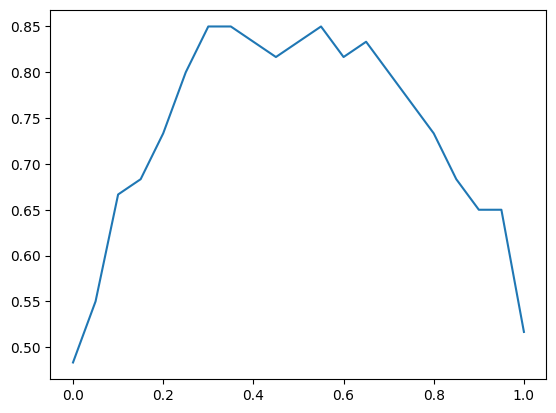

In [1024]:
# Find the right decision threshold
threshold = np.linspace(0,1,21) # first last, size#
scores = []
for t in threshold:
    churn_decision = (y_pred>= t)
    score = (y_val == churn_decision).mean()
    #print('for threshold', t, 'score', score)
    #print('%.2f %.3f' % (t, score))
    scores.append(score)
plt.plot(threshold, scores)

In [1025]:
# feature importance 
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'apgar_10min_max': 0.009,
 'apgar_10min_mean': 0.009,
 'apgar_10min_min': 0.009,
 'apgar_1min_max': -0.007,
 'apgar_1min_mean': -0.007,
 'apgar_1min_min': -0.007,
 'apgar_5min_max': 0.012,
 'apgar_5min_mean': 0.012,
 'apgar_5min_min': 0.012,
 'birth__1_natural_2_caesarean': 0.004,
 'body_weight': -0.0,
 'crp_max': 0.047,
 'crp_mean': 0.008,
 'crp_min': 0.001,
 'gender': 0.0,
 'hematocrit_max': -0.002,
 'hematocrit_mean': 0.0,
 'hematocrit_min': -0.0,
 'leukocytes_max': -0.014,
 'leukocytes_mean': 0.034,
 'leukocytes_min': 0.0,
 'map_max': -0.109,
 'map_mean': 0.078,
 'map_min': 0.009,
 'number_of_children': -0.002,
 'pco2_max': 0.001,
 'pco2_mean': 0.074,
 'pco2_min': -0.052,
 'ph_max': 0.008,
 'ph_mean': 0.011,
 'ph_min': -0.011,
 'po2_max': -0.02,
 'po2_mean': 0.06,
 'po2_min': 0.034,
 'sao2_max': 0.004,
 'sao2_mean': -0.013,
 'sao2_min': 0.003,
 'thrombocytes_max': -0.006,
 'thrombocytes_mean': 0.0,
 'thrombocytes_min': 0.027,
 'wg': 0.01}

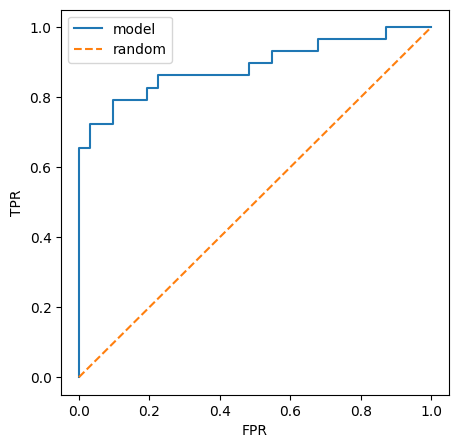

In [1033]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label ='model')
plt.plot([0, 1], [0,1], label ='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### Reduction of features

In [1053]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [1054]:
# Standardize features to ensure regularization is effective
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# L1 Regularized Logistic Regression (Lasso)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)  # C controls regularization strength (smaller C = stronger regularization)

# Fit model on training data
lasso.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = lasso.coef_.ravel()

selected_indices = np.where(coefficients != 0)[0]
X_train_reduced = X_train[:, selected_indices]
X_val_reduced = X_val[:, selected_indices]
X_full_train_reduced = X_train[:, selected_indices]

# Retrain with reduced feature set and L2 regularization
logistic = LogisticRegression(penalty='l2', solver='liblinear', C=1)  # L2 regularization
logistic.fit(scaler.fit_transform(X_train_reduced), y_train)

# Predictions and evaluation on the validation set
y_val_pred = logistic.predict(X_val_reduced)
y_val_prob = logistic.predict_proba(X_val_reduced)[:, 1]

# Classification report and AUC score
print(classification_report(y_val, y_val_pred))
print("Validation AUC: ", roc_auc_score(y_val, y_val_prob))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        31
           1       1.00      0.10      0.19        29

    accuracy                           0.57        60
   macro avg       0.77      0.55      0.45        60
weighted avg       0.76      0.57      0.45        60

Validation AUC:  0.903225806451613


In [1055]:
from sklearn.model_selection import cross_val_score

# Cross-validation with the reduced feature set
scores = cross_val_score(logistic, X_train_reduced, y_train, cv=5, scoring='roc_auc')
print("Cross-validated AUC: ", scores.mean())

Cross-validated AUC:  0.8459801587301587


#### Alternative recursive feature elimination

In [1056]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
log_reg = LogisticRegression(penalty='l2', solver='liblinear')

# Initialize RFE to reduce features down to a desired number (e.g., 15)
rfe = RFE(log_reg, n_features_to_select=27) # could have been 15
rfe.fit(X_train, y_train)

# Select the best features (this will return a mask for selected features)
selected_indices_rfe = np.where(rfe.support_)[0]  # Indices of selected features

# Reduce X_train and X_val to selected features
X_train_rfe = X_train[:, selected_indices_rfe]
X_val_rfe = X_val[:, selected_indices_rfe]

# Retrain with reduced feature set
log_reg.fit(X_train_rfe, y_train)

# Evaluate the model on the validation set
y_val_pred_rfe = log_reg.predict(X_val_rfe)
y_val_prob_rfe = log_reg.predict_proba(X_val_rfe)[:, 1]

# AUC score
print("Validation AUC (RFE): ", roc_auc_score(y_val, y_val_prob_rfe))


Validation AUC (RFE):  0.8298109010011123


In [1057]:
from sklearn.model_selection import cross_val_score

# Cross-validation with the reduced feature set
scores = cross_val_score(log_reg, X_train_rfe, y_train, cv=5, scoring='roc_auc')
print("Cross-validated AUC: ", scores.mean())



Cross-validated AUC:  0.8092619047619047


### Bootstrapping for better model evaluation

In [1039]:
from sklearn.utils import resample

# Number of bootstrap iterations
n_iterations = 1000
auc_scores = []

# Perform bootstrapping
for i in range(n_iterations):
    # Resample the training data with replacement
    X_train_bootstrap, y_train_bootstrap = resample(X_train_reduced, y_train)
    
    # Train model on bootstrap sample
    logistic.fit(X_train_bootstrap, y_train_bootstrap)
    
    # Predict on validation set
    y_val_prob = logistic.predict_proba(X_val_reduced)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val, y_val_prob)
    auc_scores.append(auc)

# Calculate mean AUC and confidence intervals
mean_auc = np.mean(auc_scores)
lower_bound = np.percentile(auc_scores, 2.5)
upper_bound = np.percentile(auc_scores, 97.5)

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval for AUC: [{lower_bound}, {upper_bound}]")


Mean AUC: 0.8605050055617351
95% Confidence Interval for AUC: [0.8186874304783093, 0.8998887652947719]


### SVM

In [955]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Initialize SVM with probability estimation for AUC calculation
svm_model = SVC(probability=True)

# Train the model
svm_model.fit(X_train_reduced, y_train)

# Predict probabilities on the validation set
y_val_prob_svm = svm_model.predict_proba(X_val_reduced)[:, 1]

# Calculate AUC
auc_svm = roc_auc_score(y_val, y_val_prob_svm)
print(f"SVM AUC: {auc_svm}")


SVM AUC: 0.9132369299221357


In [956]:
# Number of bootstrap iterations
n_iterations = 1000
auc_scores = []

# Perform bootstrapping
for i in range(n_iterations):
    # Resample the training data with replacement
    X_train_bootstrap, y_train_bootstrap = resample(X_train_reduced, y_train)
    
    svm_model = SVC(probability=True)

    # Train the model
    svm_model.fit(X_train_reduced, y_train)

    # Predict probabilities on the validation set
    y_val_prob_svm = svm_model.predict_proba(X_val_reduced)[:, 1]

    # Calculate AUC
    auc_svm = roc_auc_score(y_val, y_val_prob_svm)
    auc_scores.append(auc_svm)

# Calculate mean AUC and confidence intervals
mean_auc = np.mean(auc_scores)
lower_bound = np.percentile(auc_scores, 2.5)
upper_bound = np.percentile(auc_scores, 97.5)

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval for AUC: [{lower_bound}, {upper_bound}]")


Mean AUC: 0.9132369299221353
95% Confidence Interval for AUC: [0.9132369299221357, 0.9132369299221357]


### Random Forest

In [957]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_reduced, y_train)

# Predict probabilities on the validation set
y_val_prob_rf = rf_model.predict_proba(X_val_reduced)[:, 1]

# Calculate AUC
auc_rf = roc_auc_score(y_val, y_val_prob_rf)
print(f"Random Forest AUC: {auc_rf}")



Random Forest AUC: 0.9388209121245829


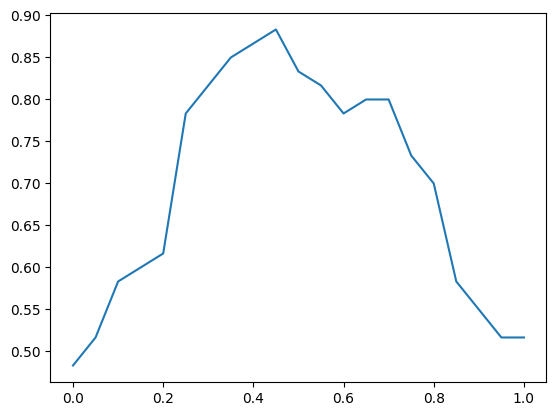

In [1041]:
threshold = np.linspace(0,1,21) # first last, size#
scores = []
for t in threshold:
    churn_decision = (y_val_prob_rf>= t)
    score = (y_val == churn_decision).mean()
    #print('for threshold', t, 'score', score)
    #print('%.2f %.3f' % (t, score))
    scores.append(score)
plt.plot(threshold, scores)


In [937]:
print(classification_report(y_val, (y_val_prob_rf>0.33).astype('int')))
print(f"Random Forest AUC: {auc_rf}")


              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.87      0.93      0.90        29

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

Random Forest AUC: 0.9388209121245829


In [1040]:
# Number of bootstrap iterations
n_iterations = 100
auc_scores = []

# Perform bootstrapping
for i in range(n_iterations):
    # Resample the training data with replacement
    X_train_bootstrap, y_train_bootstrap = resample(X_train_reduced, y_train)
    
    # Initialize Random Forest
    rf_model = RandomForestClassifier(n_estimators=100)

    # Train the model
    rf_model.fit(X_train_reduced, y_train)

    # Predict probabilities on the validation set
    y_val_prob_rf = rf_model.predict_proba(X_val_reduced)[:, 1]

    # Calculate AUC
    auc_rf = roc_auc_score(y_val, y_val_prob_rf)
    auc_scores.append(auc_rf)

# Calculate mean AUC and confidence intervals
mean_auc = np.mean(auc_scores)
lower_bound = np.percentile(auc_scores, 2.5)
upper_bound = np.percentile(auc_scores, 97.5)

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval for AUC: [{lower_bound}, {upper_bound}]")

Mean AUC: 0.9226084538375975
95% Confidence Interval for AUC: [0.9045745272525028, 0.9391129032258064]


### XG boost

In [1042]:
def parse_xgb_output(output):
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it,train,val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [1043]:
import xgboost as xgb

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train_reduced, y_train)

# Predict probabilities on the validation set
y_val_prob_xgb = xgb_model.predict_proba(X_val_reduced)[:, 1]

# Calculate AUC
auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)
print(f"XGBoost AUC: {auc_xgb}")


XGBoost AUC: 0.8954393770856507


c:\Users\hohih\ivh\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Training on the full training dataset & Test

In [1113]:
#y_full_train = df_full_train['grad_ivh']
#del df_full_train['grad_ivh']

full_train_dicts = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse = False)
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test  = dv.transform(test_dicts)

In [1114]:
# Standardize features to ensure regularization is effective
scaler = StandardScaler()
X_full_train_scaled = scaler.fit_transform(X_full_train)
# L1 Regularized Logistic Regression (Lasso)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)  # C controls regularization strength (smaller C = stronger regularization)

# Fit model on training data
lasso.fit(X_full_train_scaled, y_full_train)

# Get the coefficients
coefficients = lasso.coef_.ravel()

selected_indices = np.where(coefficients != 0)[0]
X_train_reduced = X_train[:, selected_indices]
X_test_reduced = X_test[:, selected_indices]
X_full_train_reduced = X_full_train[:, selected_indices]

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_reduced, y_train)

# Predict probabilities on the validation set
y_test_pred = rf_model.predict_proba(X_test_reduced)[:, 1] #(rf_model.predict_proba(X_test_reduced)[:, 1]>0.5).astype('int')

#print(classification_report(y_test, y_test_pred))
print("Test AUC: ", roc_auc_score(y_test, y_test_pred))

Validation AUC:  0.8462918660287081


In [1111]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_full_train_reduced, y_full_train)

# Predict probabilities on the validation set
y_test_prob_rf = rf_model.predict_proba(X_test_reduced)[:, 1]

# Calculate AUC
auc_rf = roc_auc_score(y_test, y_test_prob_rf)
print(f"Random Forest AUC: {auc_rf}")
print(classification_report(y_test, (y_test_prob_rf>0.59).astype('int')))


Random Forest AUC: 0.8582535885167465
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        38
           1       0.78      0.64      0.70        22

    accuracy                           0.80        60
   macro avg       0.79      0.77      0.77        60
weighted avg       0.80      0.80      0.79        60



### Finetuning XG boost

In [1121]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train_reduced, label=y_train)

In [1123]:
dval = xgb.DMatrix(X_val_reduced, label=y_val)

In [1124]:
watchlist = [(dtrain, 'train'),(dval, 'val')]

In [1183]:
%%capture output
xgb_params = {
    'eta': 0.05, # learning rate
    'max_depth': 6,
    'min_child_weight': 1, # same as min_samples_leaf
    'objective': 'binary:logistic', # binary classification
    'nthreads': 8, #parallelization of training

    'eval_metric': 'auc',
    'seed': 1, 
    'verbosity':1, # show only warnings
}
model = xgb.train(xgb_params, 
                  dtrain, 
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round = 300
                  )

In [1184]:
y_pred = model.predict(dval)
roc_auc_score(y_val,y_pred)

0.8943270300333704

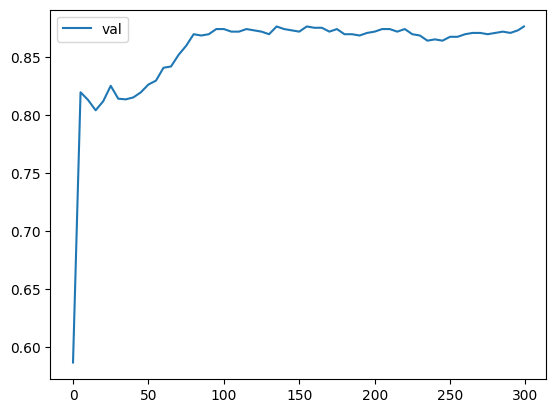

In [1162]:
df_score = parse_xgb_output(output)
#plt.plot(df_score.num_iter,df_score.train_auc, label = 'train')
plt.plot(df_score.num_iter,df_score.val_auc, label = 'val')
plt.legend()

Random Forest AUC: 0.8582535885167465
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        38
           1       0.82      0.64      0.72        22

    accuracy                           0.82        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.82      0.82      0.81        60

Random Forest AUC: 0.8582535885167465


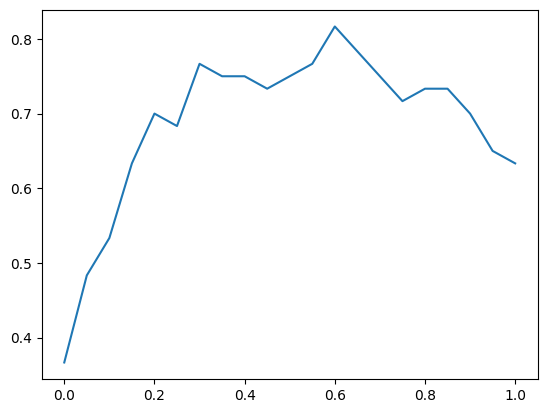

In [1117]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_full_train_reduced, y_full_train)

# Predict probabilities on the validation set
y_test_prob_rf = rf_model.predict_proba(X_test_reduced)[:, 1]

# Calculate AUC
auc_rf = roc_auc_score(y_test, y_test_prob_rf)
print(f"Random Forest AUC: {auc_rf}")


In [ ]:
threshold = np.linspace(0,1,21) # first last, size#
scores = []
for t in threshold:
    churn_decision = (y_test_prob_rf>= t)
    score = (y_test == churn_decision).mean()
    scores.append(score)
plt.plot(threshold, scores)
print(classification_report(y_test, (y_test_prob_rf>0.6).astype('int')))
print(f"Random Forest AUC: {auc_rf}")